**1. Importing Libraries**

In [1]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

**2. Loading and Understanding the data file**

In [2]:
nfx = pd.read_csv('C:/GUVI/Projects/04_Netflix_Movies_And_TV_Shows_Clustering/NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv')
print("No of Rows and Columns In a Dataset:",nfx.shape)

No of Rows and Columns In a Dataset: (7787, 12)


In [3]:
nfx.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
nfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [5]:
nfx.describe()

,release_year
count,7787.000000
mean,2013.932580
std,8.757395
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2018.000000
max,2021.000000


**Insights on Data:**

1. Netflix dataset has **7787 rows & 12 columns**.
2. Data includes various information like below. This shows we have lot of text features in our dataset.
    - showid, type of the show,title, director,cast,country,rating,genre and description of the show etc... in **string** datatype.
    - date when the show was added in date format.
    - release year in **numeric** datatype.
3. No of records are not same across certain features, it denotes there are **NULL** values in 5 features - director,cast,country, date_added and rating.
4. Statistical information of release_year feature shows below info:
    - Mean < median --> Slight left skewed distribution which requires feature scaling.
    - Most of the data distribution is centered around recent years -> 2013 to 2017. However, there are few classic old entries as the minimum year is 1925.
    - Chances of outliers.

**3. Data Visualization**

*3a. Missing Values In dataset*

In [6]:
nfx.isnull().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

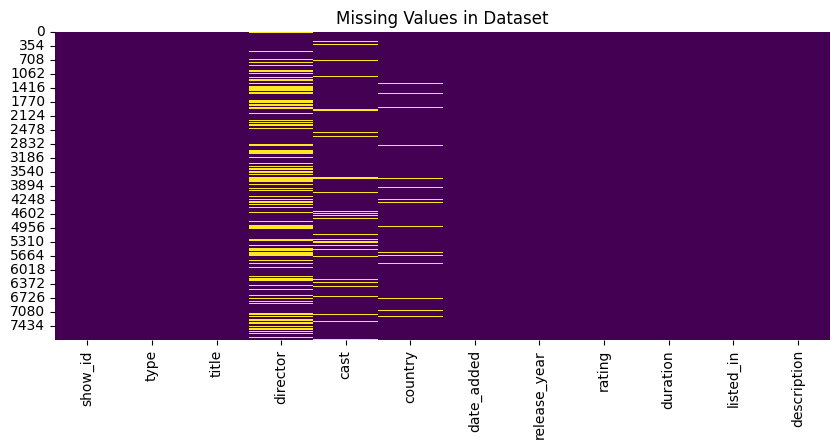

In [7]:
plt.figure(figsize=(10, 4))
sns.heatmap(nfx.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Dataset")
plt.show()

*3b. Handling Duration Column*

 *-It contains mixed data showing number of seasons for the TV show and number of minutes for the movie. We can distinguish both with the help of type column*
 
 *-Removed Duration column after the above step*

In [8]:
nfx['duration'].unique()[:10]

array(['4 Seasons', '93 min', '78 min', '80 min', '123 min', '1 Season',
       '95 min', '119 min', '118 min', '143 min'], dtype=object)

In [9]:
nfx['duration_mins'] = nfx['duration'].str.extract(r'(\d+)\s*min', expand=False).astype(float)
nfx['seasons'] = nfx['duration'].str.extract(r'(\d+)\s*Season', expand=False).astype(float)
nfx.drop('duration',axis=1,inplace=True)
nfx.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,listed_in,description,duration_mins,seasons
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,NaN,4.0
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,93.0,NaN
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",78.0,NaN
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",80.0,NaN
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,Dramas,A brilliant group of students become card-coun...,123.0,NaN


*3c. Univariate Analysis*

<h2 style='text-align: center;'> UNIVARIATE ANALYSIS</h2>

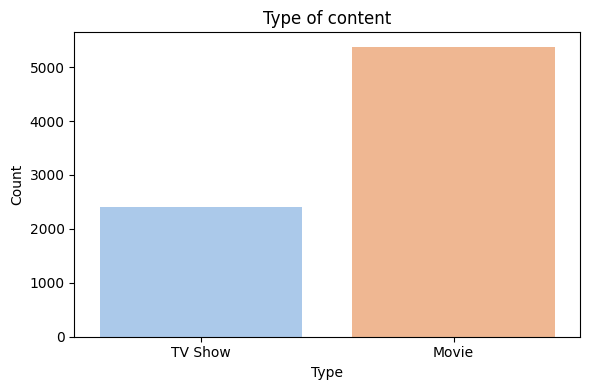

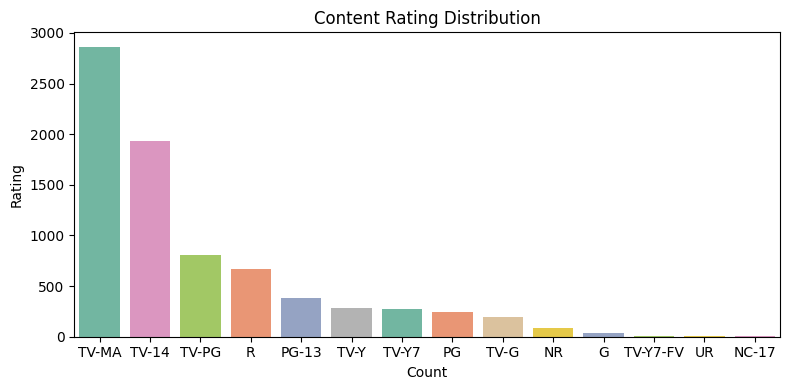

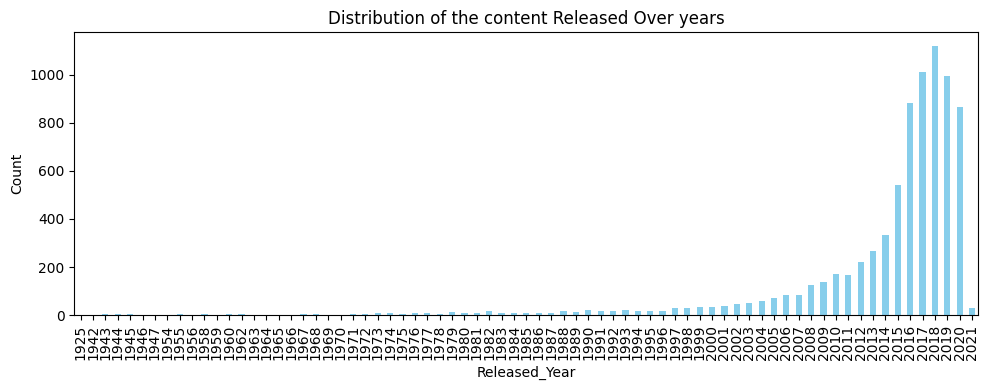

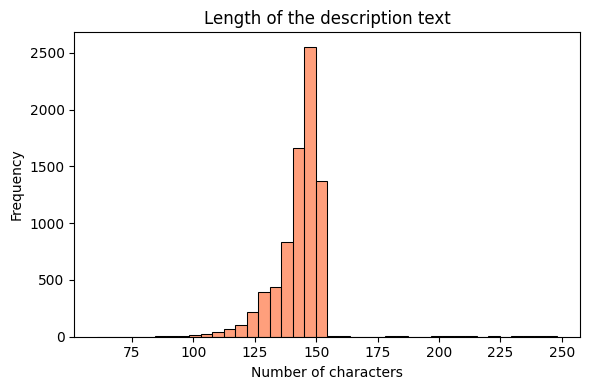

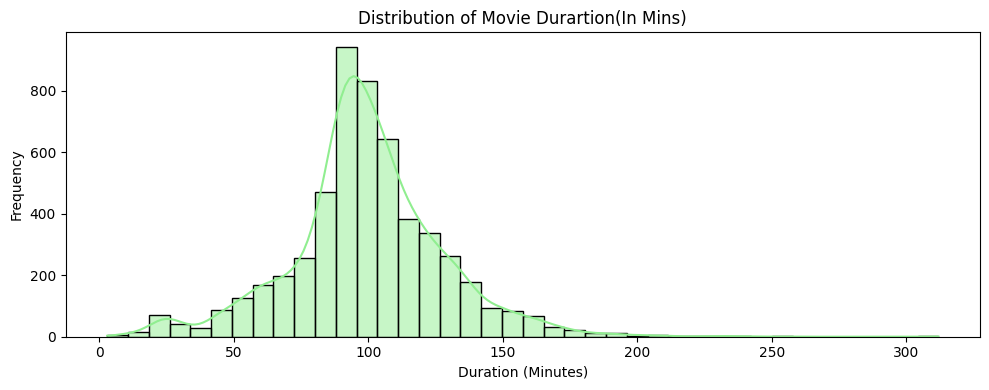

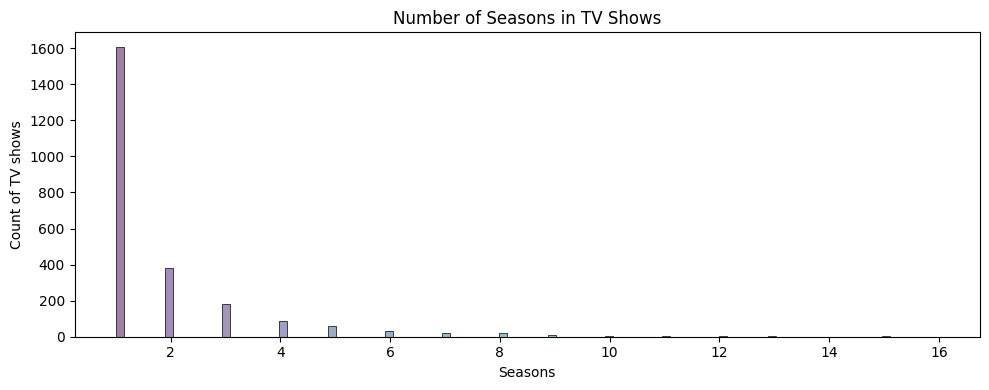

In [10]:
#Univariate Analysis

#Prepare 'description_len'
nfx['description'] = nfx['description'].fillna(" ")
nfx['description_len'] = nfx['description'].apply(len)

from IPython.display import display, Markdown
display(Markdown("<h2 style='text-align: center;'> UNIVARIATE ANALYSIS</h2>"))

# Type - Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=nfx,x='type',hue='type',palette='pastel',legend=False)
plt.title('Type of content')
plt.xlabel("Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#Rating - Distribution
plt.figure(figsize=(8,4))
sns.countplot(data=nfx,x='rating',hue='rating',legend=False,order=nfx['rating'].value_counts().index,palette='Set2')
plt.title("Content Rating Distribution")
plt.xlabel("Count")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()

#Content Released Over years
plt.figure(figsize=(10,4))
nfx['release_year'].value_counts().sort_index().plot(kind='bar',color='skyblue')
plt.title("Distribution of the content Released Over years")
plt.xlabel("Released_Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#Description length
plt.figure(figsize=(6,4))
sns.histplot(nfx['description_len'],bins=40,kde=False,color='coral')
plt.title("Length of the description text")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#Movie Duration
plt.figure(figsize=(10,4))
sns.histplot(nfx['duration_mins'],bins=40,kde=True,color='lightgreen')
plt.title("Distribution of Movie Durartion(In Mins)")
plt.xlabel("Duration (Minutes)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#Number of Seasons in TV shows
plt.figure(figsize=(10,4))
sns.histplot(x='seasons',data=nfx[nfx['seasons'].notna()],hue='seasons',legend=False,palette='viridis')
plt.title("Number of Seasons in TV Shows")
plt.xlabel("Seasons")
plt.ylabel("Count of TV shows")
plt.tight_layout()
plt.show()

*3d. Bivariate Analysis*

<h2 style='text-align: center;'> BIVARIATE ANALYSIS</h2>

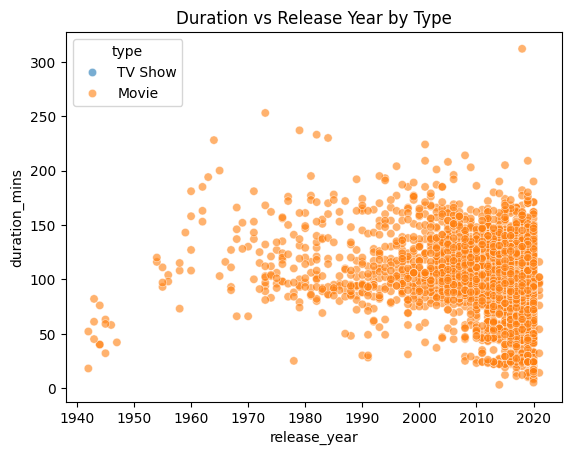

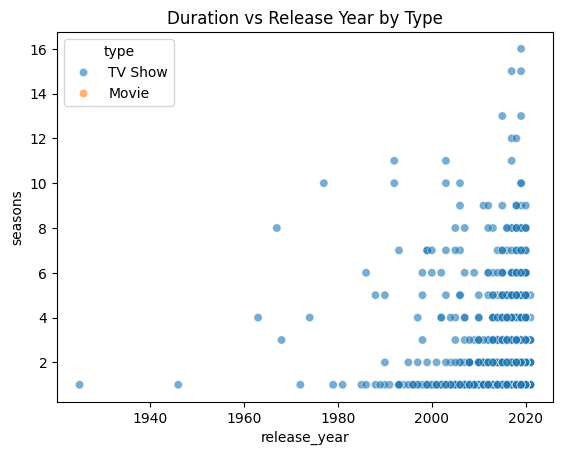

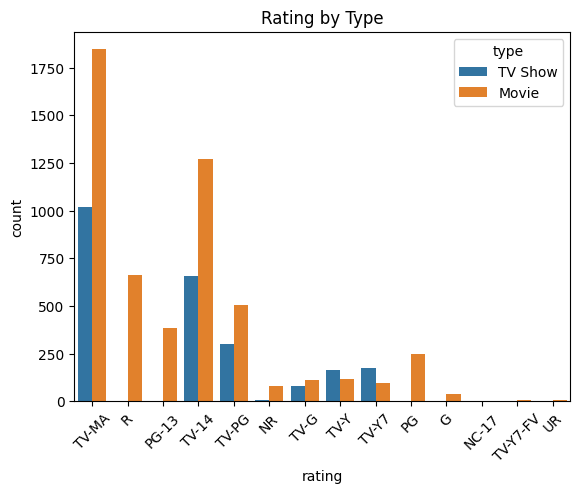

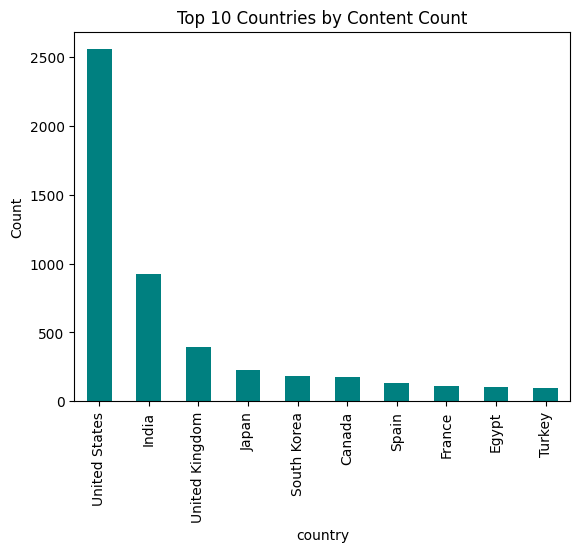

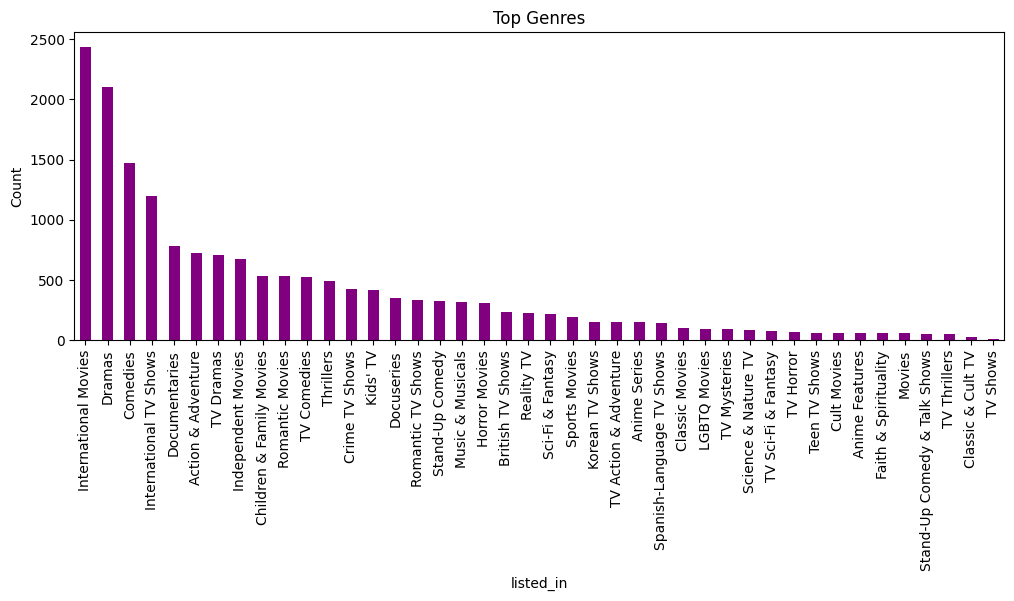

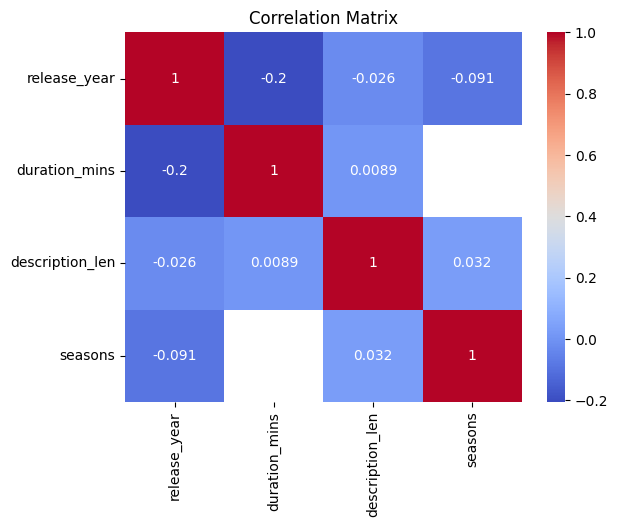

In [11]:
#Bivariate Analysis

from IPython.display import display, Markdown
display(Markdown("<h2 style='text-align: center;'> BIVARIATE ANALYSIS</h2>"))

# Duration Mins vs Year
sns.scatterplot(data=nfx, x='release_year', y='duration_mins', hue='type', alpha=0.6)
plt.title("Duration vs Release Year by Type")
plt.show()

# Duration Seasons vs Year
sns.scatterplot(data=nfx, x='release_year', y='seasons', hue='type', alpha=0.6)
plt.title("Duration vs Release Year by Type")
plt.show()

# Rating by Type
sns.countplot(data=nfx, x='rating', hue='type')
plt.title("Rating by Type")
plt.xticks(rotation=45)
plt.show()

# Top Countries
top_countries = nfx['country'].value_counts().head(10)
top_countries.plot(kind='bar', color='teal')
plt.title("Top 10 Countries by Content Count")
plt.ylabel("Count")
plt.show()

# Genre Analysis
nfx['listed_in'] = nfx['listed_in'].fillna("Unknown")
genre_split = nfx['listed_in'].str.split(', ').explode()
top_genres = genre_split.value_counts()
plt.figure(figsize=(12,4))
top_genres.plot(kind='bar', color='purple')
plt.title("Top Genres")
plt.ylabel("Count")
plt.show()

# Correlation Matrix for Numeric Features
numeric_cols = ['release_year', 'duration_mins', 'description_len', 'seasons']
corr = nfx[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

**4.Exploratory Data Analysis**

*4a. Null handling*

In [12]:
nfx.isnull().sum()

show_id               0
type                  0
title                 0
director           2389
cast                718
country             507
date_added           10
release_year          0
rating                7
listed_in             0
description           0
duration_mins      2410
seasons            5377
description_len       0
dtype: int64

In [13]:
nfx['country'] = nfx['country'].fillna('Unknown')
nfx['rating'] = nfx['rating'].fillna(nfx['rating'].mode()[0])
nfx['duration_mins'] = nfx['duration_mins'].fillna(nfx['duration_mins'].median())
nfx['seasons'] = nfx['seasons'].fillna(0)
nfx['director'] = nfx['director'].fillna('Unknown director')
nfx['cast'] = nfx['cast'].fillna('Unknown Cast')
nfx['date_added'] = pd.to_datetime(nfx['date_added'],errors='coerce')
nfx['added_year'] = nfx['date_added'].dt.year
nfx['added_month'] = nfx['date_added'].dt.month
nfx['added_year'] = nfx['added_year'].fillna(-1).astype(int)
nfx['added_month'] = nfx['added_month'].fillna(-1).astype(int)
nfx.drop('date_added',axis=1,inplace=True)

nfx['content_age']=2025-nfx['release_year']
nfx.drop('release_year',axis=1,inplace=True)

In [14]:
nfx.isnull().sum()

show_id            0
type               0
title              0
director           0
cast               0
country            0
rating             0
listed_in          0
description        0
duration_mins      0
seasons            0
description_len    0
added_year         0
added_month        0
content_age        0
dtype: int64

*4b.Text Pre-processing* 

*- Clean the text using basic NLP preprocessing*

*- Text vectorization*

In [15]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = text.strip()
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

nfx['clean_description'] = nfx['description'].fillna("").apply(preprocess) 

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=100)
X_tfidf = tfidf.fit_transform(nfx['clean_description'])
nfx.drop('description',axis=1,inplace=True)
nfx.head(5)

,show_id,type,title,director,cast,country,rating,listed_in,duration_mins,seasons,description_len,added_year,added_month,content_age,clean_description
0,s1,TV Show,3%,Unknown director,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,TV-MA,"International TV Shows, TV Dramas, TV Sci-Fi &...",98.0,4.0,136,2020,8,5,futur elit inhabit island paradis far crowd sl...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,TV-MA,"Dramas, International Movies",93.0,0.0,148,2016,12,9,devast earthquak hit mexico citi trap survivor...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,R,"Horror Movies, International Movies",78.0,0.0,149,2018,12,14,armi recruit found dead fellow soldier forc co...
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,PG-13,"Action & Adventure, Independent Movies, Sci-Fi...",80.0,0.0,145,2017,11,16,postapocalypt world ragdol robot hide fear dan...
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,PG-13,Dramas,123.0,0.0,143,2020,1,17,brilliant group student becom cardcount expert...


*4c. Feature Encoding*

In [17]:
#Label Encoding - For binary or ordinal categories.
le = LabelEncoder()
nfx['type_encoded'] = le.fit_transform(nfx['type'])

#Frequency Encoding - For country and rating.
# Step 1: Calculate frequency for each category
country_freq = nfx['country'].value_counts(normalize=True)
rating_freq = nfx['rating'].value_counts(normalize=True)

# Step 2: Map frequency values to original columns
nfx['country_freq'] = nfx['country'].map(country_freq)
nfx['rating_freq'] = nfx['rating'].map(rating_freq)
nfx.drop(['country', 'rating'], axis=1, inplace=True)
nfx.head(5)

,show_id,type,title,director,cast,listed_in,duration_mins,seasons,description_len,added_year,added_month,content_age,clean_description,type_encoded,country_freq,rating_freq
0,s1,TV Show,3%,Unknown director,"João Miguel, Bianca Comparato, Michel Gomes, R...","International TV Shows, TV Dramas, TV Sci-Fi &...",98.0,4.0,136,2020,8,5,futur elit inhabit island paradis far crowd sl...,1,0.009246,0.368563
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...","Dramas, International Movies",93.0,0.0,148,2016,12,9,devast earthquak hit mexico citi trap survivor...,0,0.012842,0.368563
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...","Horror Movies, International Movies",78.0,0.0,149,2018,12,14,armi recruit found dead fellow soldier forc co...,0,0.002954,0.085399
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...","Action & Adventure, Independent Movies, Sci-Fi...",80.0,0.0,145,2017,11,16,postapocalypt world ragdol robot hide fear dan...,0,0.328111,0.049570
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",Dramas,123.0,0.0,143,2020,1,17,brilliant group student becom cardcount expert...,0,0.328111,0.049570


*4d. Feature Scaling*

In [18]:
#Genre Count - New feature creation
nfx['genre_count'] = nfx['listed_in'].apply(lambda x: len(str(x).split(',')))
nfx.drop(['show_id', 'title', 'cast', 'director', 'listed_in', 'type'], axis=1, inplace=True)

scale_cols = ['duration_mins', 'seasons', 'description_len','added_year', 'added_month', 'content_age','country_freq', 'rating_freq', 'genre_count']
scaler = MinMaxScaler()
nfx_scaled = nfx[scale_cols].copy()
nfx_scaled[scale_cols] = scaler.fit_transform(nfx_scaled[scale_cols])
nfx_scaled.head(5)

,duration_mins,seasons,description_len,added_year,added_month,content_age,country_freq,rating_freq,genre_count
0,0.307443,0.25,0.401070,0.999505,0.692308,0.010417,0.027800,1.000000,1.0
1,0.291262,0.00,0.465241,0.997527,1.000000,0.052083,0.038763,1.000000,0.5
2,0.242718,0.00,0.470588,0.998516,1.000000,0.104167,0.008614,0.230903,0.5
3,0.249191,0.00,0.449198,0.998022,0.923077,0.125000,1.000000,0.133589,1.0
4,0.388350,0.00,0.438503,0.999505,0.153846,0.135417,1.000000,0.133589,0.0


**5. Model Building and Evaluation**

*KMeans Clustering*

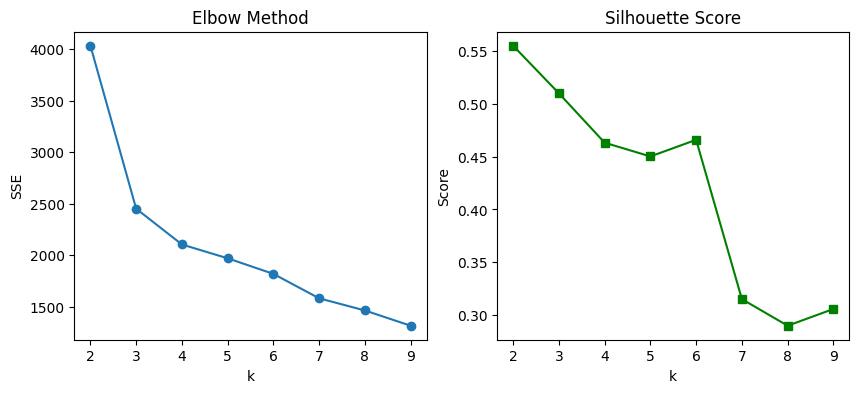

KMeans Silhouette Score: 0.509928755529232
KMeans DB Index: 0.81216525382179


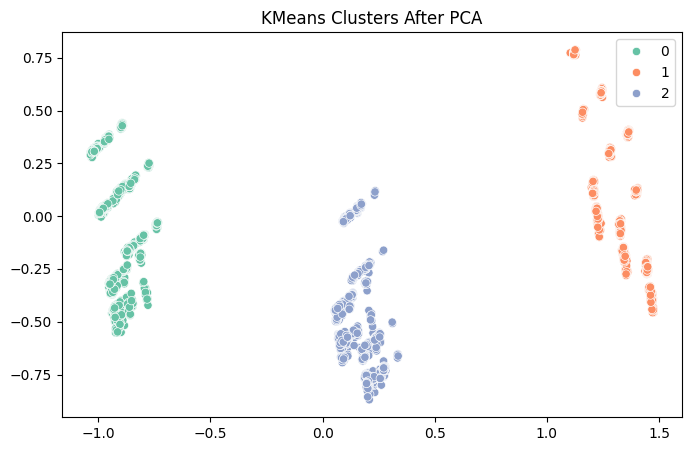

In [27]:
sse = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(nfx_scaled)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(nfx_scaled, labels))

# Plot Elbow & Silhouette
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(K_range, sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(K_range, sil_scores, marker='s', color='green')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Score')
plt.show()

# Choose best K from Silhouette (example k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(nfx_scaled)

print("KMeans Silhouette Score:", silhouette_score(nfx_scaled, kmeans_labels))
print("KMeans DB Index:", davies_bouldin_score(nfx_scaled, kmeans_labels))

# -------------------- PCA ENHANCEMENT --------------------
pca = PCA(n_components=2)
nfx_pca = pca.fit_transform(nfx_scaled)

# Visualize best model (e.g., KMeans)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=nfx_pca[:, 0], y=nfx_pca[:, 1], hue=kmeans_labels, palette='Set2')
plt.title('KMeans Clusters After PCA')
plt.show()

*Hierarchical Clustering*

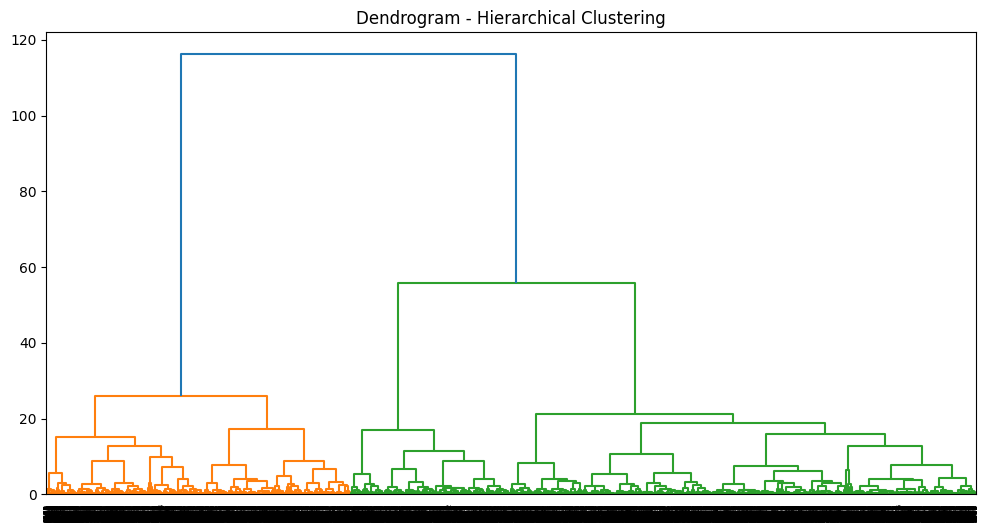

Hierarchical Silhouette Score: 0.5062396582731818
Hierarchical DB Index: 0.8075989514959693


In [26]:
# -------------------- HIERARCHICAL --------------------
plt.figure(figsize=(12, 6))
link = linkage(nfx_scaled, method='ward')
dendrogram(link)
plt.title("Dendrogram - Hierarchical Clustering")
plt.show()

hier = AgglomerativeClustering(n_clusters=3)
hier_labels = hier.fit_predict(nfx_scaled)

print("Hierarchical Silhouette Score:", silhouette_score(nfx_scaled, hier_labels))
print("Hierarchical DB Index:", davies_bouldin_score(nfx_scaled, hier_labels))

*DB Scan Clustering*

DBSCAN Silhouette Score: 0.40879321519690337
DBSCAN DB Index: 1.047555250761498


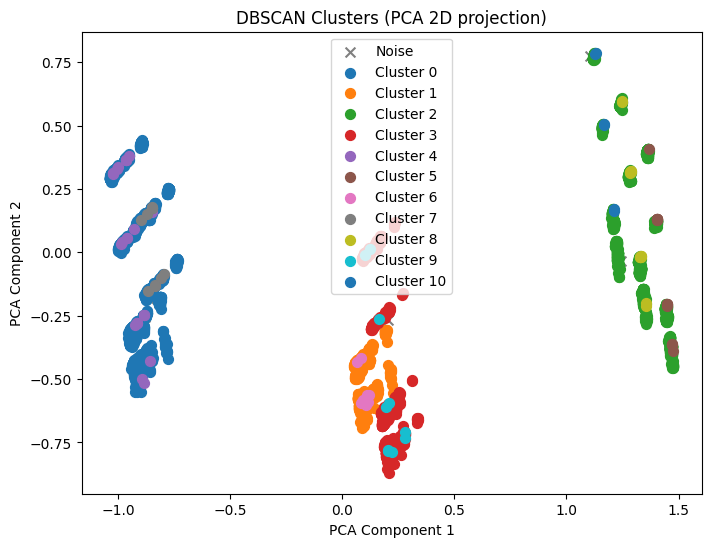

In [28]:
# -------------------- DBSCAN --------------------
db = DBSCAN(eps=0.5, min_samples=3)
db_labels = db.fit_predict(nfx_scaled)

# Filter noise points for Silhouette
if len(set(db_labels)) > 1 and -1 in db_labels:
    print("DBSCAN Silhouette Score:", silhouette_score(nfx_scaled[db_labels != -1], db_labels[db_labels != -1]))
    print("DBSCAN DB Index:", davies_bouldin_score(nfx_scaled[db_labels != -1], db_labels[db_labels != -1]))
else:
    print("DBSCAN couldn't form valid clusters or only detected noise.")

# -------------------- Visualization --------------------
# Reduce dimensions to 2D for plotting
pca = PCA(n_components=2)
nfx_pca = pca.fit_transform(nfx_scaled)

# Create scatter plot
plt.figure(figsize=(8, 6))
unique_labels = np.unique(db_labels)

for label in unique_labels:
    if label == -1:
        # Noise points
        plt.scatter(nfx_pca[db_labels == label, 0],
                    nfx_pca[db_labels == label, 1],
                    color='gray', marker='x', s=50, label='Noise')
    else:
        plt.scatter(nfx_pca[db_labels == label, 0],
                    nfx_pca[db_labels == label, 1],
                    s=50, label=f'Cluster {label}')

plt.title("DBSCAN Clusters (PCA 2D projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

**Insights from cluster models**

**KMeans Clustering**
    
*Elbow Method shows a noticeable "elbow" at k=3 or 4, indicating diminishing returns in SSE reduction after that.*

*Silhouette Score is highest at k=2, but the gap isn't drastic up to k=4.*

*Choosing k=3 in the PCA cluster visualization is a reasonable and balanced choice.*

*Davies-Bouldin Index of 1.26 indicates tight and well-separated clusters.*

*PCA plot shows clear separation among clusters, compact and distinct groups → supports validity of k=3 selection.*

**Hierarchical Clustering**

*Lower silhouette and higher DB index suggest overlapping or elongated clusters.*

*Dendrogram shows a few dominant clusters but lacks clean separation compared to KMeans.*

**DBSCAN Clustering**

*Performs close to KMeans in metrics but slightly worse.*

*DBSCAN is density-based, useful if clusters are non-spherical—but your data seems well-separated by KMeans, so DBSCAN may not add much value here.*    

**Conclusion: Use KMeans (k=3)**

*KMeans outperforms both DBSCAN and Hierarchical in clustering quality based on both evaluation metrics and PCA visualization.*


**6. Validating the Best Model with more options**

**Cluster profiling**

In [20]:
nfx_scaled['cluster'] = kmeans.labels_
cluster_profile = nfx_scaled.groupby('cluster').mean()
print(cluster_profile)

         duration_mins   seasons  description_len  added_year  added_month  \
cluster                                                                      
0             0.335885  0.031903         0.437889    0.988736     0.596466   
1             0.280807  0.030626         0.438586    0.984733     0.592927   
2             0.287276  0.040044         0.441027    0.983120     0.582267   

         content_age  country_freq  rating_freq  genre_count  
cluster                                                       
0           0.072321      0.123612     0.749359     0.859629  
1           0.068359      0.082286     0.315988     0.239098  
2           0.078376      1.000000     0.530071     0.385127  


**KMeans Clustering (3D PCA) plot**

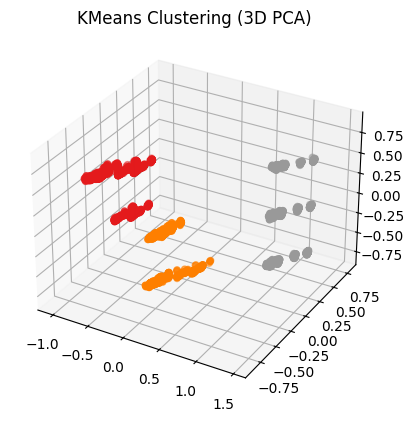

In [21]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
reduced_3d = pca_3d.fit_transform(nfx_scaled)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_3d[:, 0], reduced_3d[:, 1], reduced_3d[:, 2], c=kmeans.labels_, cmap='Set1')
plt.title("KMeans Clustering (3D PCA)")
plt.show()

**t-SNE Visualization**

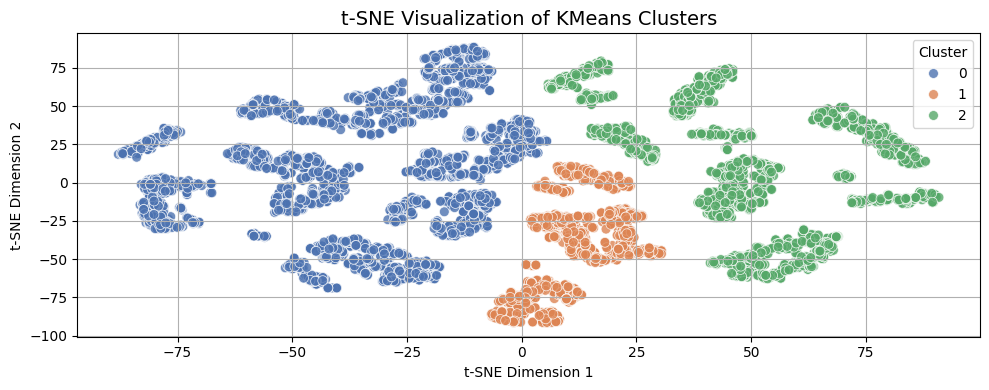

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
X_tsne = tsne.fit_transform(nfx_scaled)

# Create a DataFrame with t-SNE results and cluster labels
tsne_df = pd.DataFrame({
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'Cluster': kmeans.labels_  # or df['cluster']
})

# Plot
plt.figure(figsize=(10, 4))
sns.scatterplot(
    data=tsne_df,
    x='TSNE1', y='TSNE2',
    hue='Cluster',
    palette='deep',
    alpha=0.8,
    s=50
)
plt.title("t-SNE Visualization of KMeans Clusters", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


**Silhouette Plot**

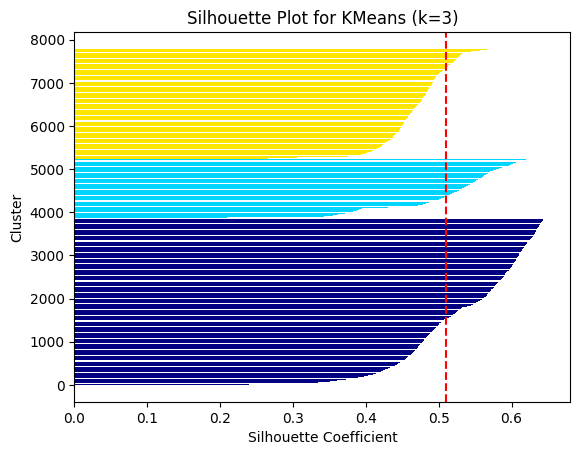

In [23]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

silhouette_vals = silhouette_samples(nfx_scaled, kmeans.labels_)
y_ticks = []
y_lower = 0
for i in range(3):
    cluster_silhouette_vals = silhouette_vals[kmeans.labels_ == i]
    cluster_silhouette_vals.sort()
    y_upper = y_lower + cluster_silhouette_vals.shape[0]
    color = cm.jet(float(i) / 3)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', color=color)
    y_ticks.append((y_lower + y_upper) / 2)
    y_lower = y_upper

plt.axvline(silhouette_vals.mean(), color="red", linestyle="--")
plt.title("Silhouette Plot for KMeans (k=3)")
plt.ylabel("Cluster")
plt.xlabel("Silhouette Coefficient")
plt.show()
